In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import pygame,time 

In [48]:
neurons = 50
M = neurons//2

x = tf.cast(tf.linspace(0,1,M)[:,None], tf.float32)

sigma = lambda x,alpha,beta : 1./(1.+ tf.math.exp(-alpha*x -beta ))

value = int((neurons - 10)/10) + 4
# value = 10.

uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=1)
uniform_int_beta = tf.initializers.RandomUniform(minval=-value, maxval=value,seed=2)


alpha = uniform_int_alpha(shape=(neurons,))
beta = uniform_int_beta(shape=(neurons,))

C = -beta/alpha

In [49]:
good_alpha = []
good_beta = []
C_good = []
counter = 0
for i in tnrange(len(alpha)):
    value = (2.945)/alpha[i]
    low = C[i] - value
    high = C[i] + value
    
#     distance_I = tf.norm(tf.constant(np.array([low,high]), tf.float32))
#     distance_x = tf.norm(tf.constant(np.array([x[0],x[-1]]), tf.float32))
    
#     isclose = np.isclose(distance_I, distance_x)
#     if distance_I < distance_x or isclose:
#     if low > 0 and high > 0:
#     if low > 0 and high > 0:

#     if (low >= x[0] and high > x[0]):
#         if x[0]<low and x[-1]> high: 
#             if alpha[i]>0.0:
# #                 counter += 1
#                 print('counter',i)
#                 print(f'{x[0]} < {low}')
#                 print(f'{x[-1]} > {high}')
    good_alpha.append(alpha[i])
    good_beta.append(beta[i])
    C_good.append(C[i])     
#     print(f'sigma :{sigma(x,alpha[i], beta[i])[-1]}')
#     print(f'Distance I.:{distance_I}')
#     print(f'Distance x.:{distance_x}')
#     print(f'Is close :{np.isclose(sigma(C[i],alpha[i], beta[i]),0.5)}')
#     print(f'high value:{high}')
#     plt.plot(x,sigma(x,alpha[i], beta[i]))
#     plt.hlines(y = sigma(C[i],alpha[i], beta[i]),xmin= low, xmax=high, colors='red', linestyles='-')
#     plt.vlines(x = C[i], ymin=0.04, ymax= 1.,colors='b', linestyles='-')
#     plt.vlines(x = low, ymin=0.04, ymax= 1.,colors='g', linestyles='--')
#     plt.vlines(x = high, ymin=0.04, ymax= 1.,colors='g', linestyles='--')        

#     plt.title(f' i :{i}  C:{C[i]} a :{alpha[i]} b {beta[i]}')
#     plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
def S_matrices(x_m_minus_2,alpha,beta):
    with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as outer:
        with tf.autodiff.ForwardAccumulator(primals=x_m_minus_2,tangents=tf.ones_like(x_m_minus_2)) as inner:
            S0 = sigma(x_m_minus_2,alpha,beta )
        S1 = inner.jvp(S0)
    S2 = outer.jvp(S1)  
    return S0,S1,S2


def B_matrices(init_array,alpha,beta):
#     xk = tf.constant(init_array,dtype=tf.float32)
    xk = init_array
    with tf.autodiff.ForwardAccumulator(primals=xk,tangents=tf.ones_like(xk)) as tape:
        B0 = sigma(xk,alpha,beta )
    B1 = tape.jvp(B0)
    return B0,B1

In [51]:
# neurons = counter
# M = neurons//2
neurons,M

(50, 25)

In [52]:
def test(C_good):
    best_error = np.inf
    for C in C_good:
        beta = -C*alpha
        x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
        k = 1.
        S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
        int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
        B0,B1 = B_matrices(int_array,alpha,beta)

        fg = np.zeros((M,1))
        SB_matrix = np.zeros((M,neurons))
        lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
        rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

        lhs_BC =  B0
        rhs_BC =  tf.zeros((2,1))
        # 

        # First row == B0[0]
        SB_matrix[0] = lhs_BC[0]
        # Last row == B0[-1]
        SB_matrix[-1] = lhs_BC[-1]
        # inbetween == rhs_eqn
        SB_matrix[1:-1] = lhs_eqn

        # FG matrix
        # First row == B0[0]
        fg[0] = rhs_BC[0]
        # Last row == B0[-1]
        fg[-1] = rhs_BC[-1]
        # inbetween == rhs_eqn
        fg[1:-1] = rhs_eqn

        weight = tf.linalg.pinv(SB_matrix)@fg
        weight = tf.cast(weight, tf.float32)
        u_hat = sigma(x, alpha, beta)@weight
        u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
        error = tf.norm(u_hat- u(x))
        residue = SB_matrix@weight - fg
        res_nrom = tf.norm(residue)
        res_mse = tf.reduce_mean(tf.square(residue))
        if error < best_error:
            if C>0:
                print(f'Residue Norm  : {res_nrom}')
                print(f'Residue mse  : {res_mse}')
                print(f'Error : {tf.norm(error)}') 
                best_error = error
                C_best = C
                print(f'C     : {C}\n')  
                
    return C_best       

Residue Norm  : 62.94590377807617
Residue mse  : 158.4874725341797
Error : 3.4153964519500732
C     : 5.115394115447998

Residue Norm  : 4.783527851104736
Residue mse  : 0.9152854681015015
Error : 0.23516975343227386
C     : 1.9981719255447388

Residue Norm  : 0.639896035194397
Residue mse  : 0.016378678381443024
Error : 0.07130920141935349
C     : 1.332850694656372

Residue Norm  : 0.14930111169815063
Residue mse  : 0.000891632866114378
Error : 0.025543341413140297
C     : 1.0958292484283447



2023-02-03 13:32:58.185064: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3
2023-02-03 13:32:58.195554: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3
2023-02-03 13:32:58.347954: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3
2023-02-03 13:32:58.391127: E ./tensorflow/core/kernels/linalg/svd_op_impl.h:110] Eigen::BDCSVD failed with error code 3


Residue Norm  : 0.14930111169815063
Residue mse  : 0.000891632866114378
Error : 0.025543341413140297
mse Error  : 2.6098492526216432e-05


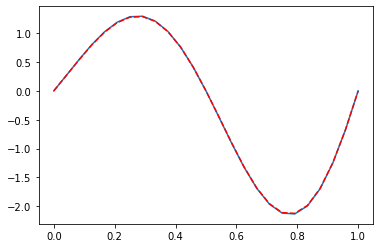

In [53]:
C_best = test(C_good)
beta = -C_best*alpha
x_m_minus_2 = tf.linspace(x[1],x[-2],M-2)
k = 1.
S0,S1,S2 = S_matrices(x_m_minus_2,alpha,beta)
int_array = tf.concat([x[0],x[-1]],axis=0)[:,None]
B0,B1 = B_matrices(int_array,alpha,beta)

fg = np.zeros((M,1))
SB_matrix = np.zeros((M,neurons))
lhs_eqn = S2 + (4.*tf.pow(k*np.pi,2) - 1.)*S0
rhs_eqn = 4.*k*np.pi*tf.math.exp(x_m_minus_2)*tf.math.cos(2.*k*np.pi*x_m_minus_2)

lhs_BC =  B0
rhs_BC =  tf.zeros((2,1))
# 

# First row == B0[0]
SB_matrix[0] = lhs_BC[0]
# Last row == B0[-1]
SB_matrix[-1] = lhs_BC[-1]
# inbetween == rhs_eqn
SB_matrix[1:-1] = lhs_eqn

# FG matrix
# First row == B0[0]
fg[0] = rhs_BC[0]
# Last row == B0[-1]
fg[-1] = rhs_BC[-1]
# inbetween == rhs_eqn
fg[1:-1] = rhs_eqn

weight = tf.linalg.pinv(SB_matrix)@fg
weight = tf.cast(weight, tf.float32)
u_hat = sigma(x, alpha, beta)@weight
u = lambda x: tf.math.exp(x)*tf.math.sin(2.*k*np.pi*x)
error = tf.norm(u_hat- u(x))
mse = tf.reduce_mean(tf.square(u_hat- u(x)))
residue = SB_matrix@weight - fg
res_nrom = tf.norm(residue)
res_mse = tf.reduce_mean(tf.square(residue))
print(f'Residue Norm  : {res_nrom}')
print(f'Residue mse  : {res_mse}')
print(f'Error : {tf.norm(error)}') 
print(f'mse Error  : {mse}')
plt.plot(x,u(x))
plt.plot(x,u_hat, 'r--')
plt.show()              
                

In [42]:
fg.shape,SB_matrix.shape

((2, 1), (2, 4))

In [43]:
tf.linalg.pinv(SB_matrix)

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[ 16.14932338,   0.12337641],
       [ 43.40875412,  -0.09734484],
       [-29.44526512,   0.48869309],
       [-31.1011581 ,   0.50230512]])>

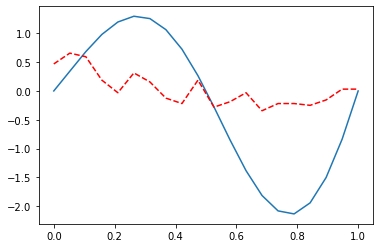

In [65]:
new_SB = np.zeros(shape = (M,neurons))
new_SB.shape

(20, 41)

In [ ]:
r,c = new_SB.shape[0],new_SB.shape[1]
for row in range(r):
    if row == 0:
        new_SB[row] = lhs_BC[row]
    elif row == new_SB.shape[0] - 1:  
        new_SB[row] = lhs_BC[-1]

In [428]:
new_SB[0].shape

(100,)

In [429]:
lhs_BC[0].shape

TensorShape([100])

In [431]:
new_SB[0] = lhs_BC[0]
new_SB[-1]= lhs_BC[-1]

In [445]:
tf.reduce_all(new_SB[1:-1] == lhs_eqn)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [412]:
LHS

<tf.Tensor: shape=(50, 100), dtype=float32, numpy=
array([[1.1737227e+00, 2.3880198e+01, 9.2181482e+00, ..., 1.1251283e+00,
        3.0336025e+00, 2.8613085e+01],
       [1.4259485e+00, 2.3689878e+01, 9.5743074e+00, ..., 1.3709230e+00,
        3.4274979e+00, 2.8272150e+01],
       [1.7300310e+00, 2.3498653e+01, 9.9387808e+00, ..., 1.6682122e+00,
        3.8648982e+00, 2.7924314e+01],
       ...,
       [3.7304699e+01, 1.4598227e+01, 2.9260271e+01, ..., 3.7353287e+01,
        3.5444817e+01, 9.8653326e+00],
       [7.2437488e-03, 6.2720788e-01, 2.1352848e-01, ..., 6.7874691e-03,
        3.4010451e-02, 7.6627004e-01],
       [9.9275631e-01, 3.7279215e-01, 7.8647149e-01, ..., 9.9321246e-01,
        9.6598959e-01, 2.3372991e-01]], dtype=float32)>

In [404]:
LHS = tf.concat([lhs_eqn,lhs_BC],axis = 0)
LHS.shape

TensorShape([50, 100])

In [397]:
RHS = tf.concat([lhs_BC, rhs],axis = 0)
RHS.shape

TensorShape([4, 100])

In [400]:
RHS

<tf.Tensor: shape=(4, 100), dtype=float32, numpy=
array([[0.00724375, 0.6272079 , 0.21352848, 0.801585  , 0.96115243,
        0.67351145, 0.88514954, 0.02674913, 0.9973042 , 0.01589064,
        0.9984901 , 0.5659067 , 0.510195  , 0.97246516, 0.00421547,
        0.8130133 , 0.9935762 , 0.90384364, 0.9975593 , 0.8539658 ,
        0.74346155, 0.8845339 , 0.1514901 , 0.6545472 , 0.5791359 ,
        0.09567159, 0.4627746 , 0.85872096, 0.4624861 , 0.18535994,
        0.52597934, 0.05640417, 0.02253815, 0.9945591 , 0.13838366,
        0.0120892 , 0.9903025 , 0.9979346 , 0.03362466, 0.8409074 ,
        0.00388385, 0.03618183, 0.02783983, 0.7500773 , 0.9461747 ,
        0.00195814, 0.00395232, 0.03520233, 0.23388794, 0.00229428,
        0.08415455, 0.00340514, 0.93978983, 0.0305384 , 0.12039144,
        0.99599874, 0.79859173, 0.6034649 , 0.00315262, 0.98919934,
        0.28998542, 0.92572224, 0.00160515, 0.09033588, 0.11669607,
        0.9413936 , 0.39743632, 0.00396757, 0.22520904, 0.01728561

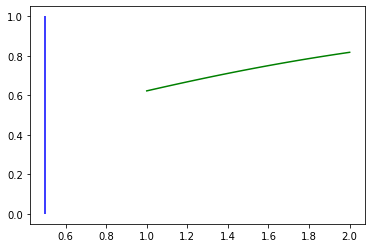

In [81]:
sigma = lambda x,alpha,beta : 1./(1.+ tf.math.exp(-alpha*x -beta ))
alpha = 100.
beta = -80.
# plt.plot(x,sigma( x,alpha,beta),'o' )
# plt.vlines(x= - beta/alpha, ymin=0.0, ymax=1., colors='r' )

alpha = 1.
beta = -0.5
plt.plot(x,sigma( x,alpha,beta),'g' )
plt.vlines(x= - beta/alpha, ymin=0.0, ymax=1., colors='b' )

In [82]:
with tf.GradientTape() as tape1:
    tape1.watch(x)
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        sigma = sigma( x,alpha,beta)
    sigma_x = tape2.gradient(sigma,x)
sigma_xx = tape1.gradient(sigma_x,x)

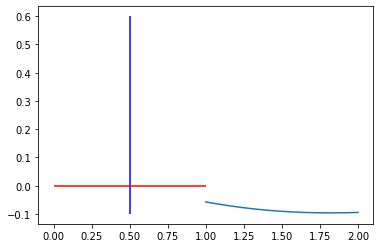

In [83]:
# plt.plot(x,sigma)
plt.plot(x,sigma_xx)
plt.vlines(x= - beta/alpha, ymin=-0.1, ymax=.6, colors='b' )
plt.hlines(y = 0.0, xmin=0.0, xmax=1.,colors = 'red')

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 6.055811  , -0.640316  ,  1.60466   , -1.7184372 , -3.9489079 ,
       -0.89121246, -2.5133858 ,  4.4235573 , -7.277996  ,  5.078163  ,
       -7.9928875 , -0.3263626 , -0.0501976 , -4.3869305 ,  6.72587   ,
       -1.8088741 , -6.204672  , -2.757761  , -7.4006805 , -2.1736012 ,
       -1.3095856 , -2.505949  ,  2.1205673 , -0.7865696 , -0.39289474,
        2.7646408 ,  0.18360329, -2.221178  ,  0.18503189,  1.8220882 ,
       -0.12801361,  3.467268  ,  4.6396923 , -6.4102936 ,  2.2508068 ,
        5.419422  , -5.693716  , -7.606613  ,  4.1332836 , -2.0492249 ,
        6.8271236 ,  4.03981   ,  4.3729877 , -1.3526459 , -3.528225  ,
        7.672367  ,  6.8055286 ,  4.0748386 ,  1.4602909 ,  7.4769707 ],
      dtype=float32)>

In [97]:
-2.945/alpha_i, 2.945/alpha_i

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.48630977>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48630977>)

In [112]:
tf.nn.sigmoid(x_n)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.7337417 , 0.7376016 , 0.74142516, 0.74521226, 0.7489627 ,
       0.7526763 , 0.7563527 , 0.75999206, 0.7635939 , 0.7671583 ,
       0.77068514, 0.77417433, 0.7776257 , 0.7810391 , 0.78441477,
       0.78775245, 0.79105234, 0.79431427, 0.7975383 , 0.80072445,
       0.8038728 , 0.8069835 , 0.8100564 , 0.8130917 , 0.8160896 ,
       0.81905   , 0.82197326, 0.8248593 , 0.8277084 , 0.83052075,
       0.83329636, 0.8360355 , 0.8387383 , 0.84140503, 0.84403586,
       0.84663105, 0.8491907 , 0.85171515, 0.8542046 , 0.8566593 ,
       0.8590795 , 0.8614654 , 0.86381733, 0.86613554, 0.8684203 ,
       0.87067187, 0.87289053, 0.8750767 , 0.87723047, 0.8793522 ],
      dtype=float32)>

In [116]:
C+(2.945/alpha_i)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9863098>

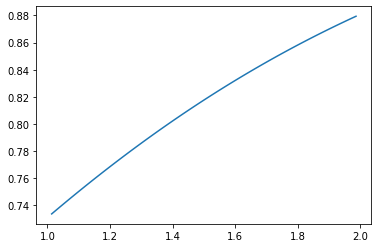

In [133]:
x_n = tf.linspace(C-(2.945/alpha_i),C+(2.945/alpha_i),100)[:,None]
plt.plot(x_n, tf.nn.sigmoid(x_n))

In [120]:
np.intersect1d([1, 3, 4, 3], [3.5, 0.5, 2, 1.5])


array([], dtype=float64)

In [140]:
np.intersect1d(x,x_n)

array([], dtype=float32)

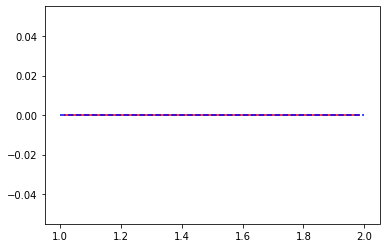

In [107]:
C = 1.5
plt.hlines(y = 0.0, xmin=C-(2.945/alpha_i), xmax=C + (2.945/alpha_i),colors = 'red')
plt.hlines(y = 0.0, xmin=x[0], xmax=x[-1],colors = 'blue',linestyles='--')

In [74]:
x[0], x[-1]

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>)

In [104]:
with tf.GradientTape() as tape1:
    tape1.watch(x)
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        sigma = tf.nn.sigmoid(x)
    sigma_x = tape2.gradient(sigma,x)
sigma_xx = tape1.gradient(sigma_x,x)

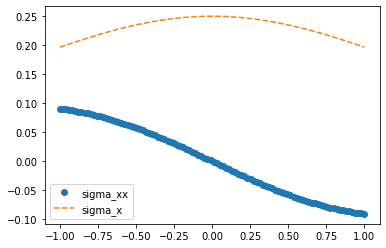

In [107]:
plt.plot(x,sigma_xx,'o', label = 'sigma_xx')
plt.plot(x,sigma_x, '--',label = 'sigma_x')
# plt.plot(x,sigma, label = 'sigma')
plt.legend()
plt.show()

In [76]:
tf.argmin(tf.abs(sigma_xx))[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [ ]:
with tf.GradientTape() as tape1:
    tape1.watch(t)
    with tf.GradientTape() as tape2:
        tape2.watch(t)
        y = self.constrained_expression(t,neurons,beta)
    y_t = tape2.gradient(y,t)
y_tt = tape1.gradient(y_t,t)

In [ ]:
def loss_function(self,t,neurons,beta):
    with tf.GradientTape() as tape1:
        tape1.watch(t)
        with tf.GradientTape() as tape2:
            tape2.watch(t)
            y = self.constrained_expression(t,neurons,beta)
        y_t = tape2.gradient(y,t)
    y_tt = tape1.gradient(y_t,t)

In [ ]:


def weights_biase_init(shape,neurons):
    value = int((neurons - 10)/10) + 4

    uniform_int_alpha = tf.initializers.RandomUniform(minval=-value, maxval=value,seed = 1)
    uniform_int_beta = tf.initializers.RandomUniform(minval=-10, maxval=10,seed = 2)
    
#     weights = Xavier_Glorot_initializer(shape)
    weights = uniform_int_alpha(shape)
    bias = uniform_int_b((neurons,))    
    return weights,bias

def sigma(t,neurons):
    num_cols = t.shape[-1]
    shape = [num_cols,neurons]
    weights,bias = weights_biase_init(shape,neurons)
    sigma_matrix = tf.tanh(tf.matmul(t,weights)+bias)
    beta,_ = weights_biase_init([neurons,1],neurons)
    return beta,sigma_matrix

In [ ]:
def fun(x):
    with tf.GradientTape() as tape1:
        tape1.watch(x)
        with tf.GradientTape() as tape2:
            tape2.watch(x)
            va = sigma(x,alpha,beta)
        fir_der = tape2.gradient(va,x)
    sigma_xx = tape1.gradient(fir_der,x)    
    return sigma_xx

def dfun(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        func = fun(x)
    dfunc = tape.gradient(func,x)
    
    return x - (func/dfunc)